In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
""" SPLIT THE TEXT INTO TRAIN AND TEST SET"""
with open('../corpora/indices_text.txt', 'r') as f:
    train_data = eval(f.read())

train_data = torch.tensor(train_data, dtype=torch.long)

with open('../corpora/indices_text_test.txt', 'r') as f:
    test_data = eval(f.read())

test_data = torch.tensor(test_data, dtype=torch.long)

with open('../corpora/indices_text_valid.txt', 'r') as f:
    val_data = eval(f.read())

val_data = torch.tensor(val_data, dtype=torch.long)


In [3]:
def get_batch(split, block_size = 8, batch_size = 128):
    """
    Generates a batch of input and target sequences for training or validation.

    Args:
        split (str): Either 'train' or 'val', determines which dataset to use.

    Returns:
        x (torch.Tensor): Batch of input sequences of shape (batch_size, block_size).
        y (torch.Tensor): Batch of target sequences (next tokens) of shape (batch_size, block_size).
    """
    # Select the appropriate dataset based on the split
    data = train_data if split == 'train' else val_data
    # Randomly choose starting indices for each sequence in the batch
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # Create input sequences of length block_size
    x = torch.stack([data[i:i+block_size] for i in ix])
    # Create target sequences by shifting input by one position
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y


In [4]:
with open ("../corpora/Shakespeare_byte.txt", 'r') as f:
   shakespeare_byte_train = eval(f.read())

with open('../corpora/vocab_train.txt', 'r') as f:
    vocab = eval(f.read())

indices = np.arange(0,len(vocab),1)
inidces = indices.astype(int).tolist()
value_byte = dict(zip(indices,vocab))

def decode_characters(input):
    """
    Decodes a list of integer indices into their corresponding characters using a predefined vocabulary mapping.

    Args:
        input (list of int): A list of integer indices representing encoded characters.

    Returns:
        str: The decoded string, where underscores ('_') are replaced with spaces.

    Notes:
        - The function relies on a global dictionary `value_byte` that maps indices to characters.
        - The decoded characters are joined into a single string.
        - Underscores in the decoded string are replaced with spaces for readability.
    """
    decoded = [] #given the input, we will decode it back to characters
    for i in range(0,len(input)):
        decoded.append(value_byte[input[i]]) #using the translation dctionary: value_byte
    # make it prettier by joining list to actual words and replacing underscores with spaces
    decoded = ''.join(decoded)
    decoded = decoded.replace('_', ' ')
    return decoded

In [5]:
# calculate the perplexity of the embedding
import math

def perplexity(test_indices, embedding):
    """
    Compute perplexity for a neural n-gram model using the trained embedding.
    Args:
        test_indices (list or array): Sequence of token indices (integers).
    Returns:
        float: Perplexity value.
    """
    log_prob = 0.0
    M = 0

    # Convert embedding to torch tensor if needed
    if isinstance(embedding, np.ndarray):
        emb = torch.from_numpy(embedding).float()
    else:
        emb = embedding

    for i in range(len(test_indices) - 1):
        prev_token = test_indices[i]
        w = test_indices[i + 1]

        # context is previous token for bigram
        logits = emb[prev_token]
        probs = torch.softmax(logits, dim=-1)
        p = probs[w]

        # Avoid log(0)
        if p == 0.0:
            p = 1e-9

        log_prob += math.log(p)
        M += 1

    avg_ll = log_prob / M
    pp = math.exp(-avg_ll)
    print(f"Perplexity: {pp:.2f}")
    return pp

In [6]:
global_loss = []
global_val_loss = []

class BigramLanguageModel(nn.Module):
    """
    A simple bigram language model implemented using PyTorch.
    This model learns a (vocab_size x vocab_size) embedding matrix that predicts the next token
    given the current token, using a bigram approach.
    """

    def __init__(self, vocab_size):
        """
        Initializes the BigramLanguageModel.

        Args:
            vocab_size (int): The size of the vocabulary.
        """
        super().__init__()
        # Initialize the embedding matrix with small random values centered around 0
        limit = 1 / np.sqrt(vocab_size)
        self.token_embedding_table = (
            (np.random.rand(vocab_size, vocab_size).astype(np.float32) * 2 - 1) * limit
        )
        # Convert the embedding matrix to a torch.nn.Parameter for optimization
        self.embedding_param = torch.nn.Parameter(torch.from_numpy(self.token_embedding_table))
        self.embedding_param.data = self.embedding_param.data.float()

        # AdamW optimizer for parameter updates
        self.optimizer = torch.optim.AdamW([self.embedding_param], lr=1e-2)
        self.vocab_size = vocab_size
        
        # save loss for later reference
        self.current_loss = 0
        self.validation_loss = 0

    def calculate_softmax(self, x):
        """
        Computes the softmax of the input tensor along the last dimension.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Softmax probabilities.
        """
        exp_x = torch.exp(x - torch.max(x, dim=-1, keepdim=True).values)
        return exp_x / torch.sum(exp_x, dim=-1, keepdim=True)

    def calculate_cross_entropy(self, y_hatless, y_hat):
        """
        Computes the cross-entropy loss between the target and predicted logits.

        Args:
            y_hatless (torch.Tensor): Target tensor of shape (batch, seq_len).
            y_hat (torch.Tensor): Predicted logits of shape (batch, seq_len, vocab_size).

        Returns:
            torch.Tensor: Scalar loss value.
        """
        # Get vocab size from logits shape
        _, _, vocab_size = y_hat.shape
        # Flatten logits and targets for loss computation
        y_hat = y_hat.reshape(y_hat.shape[0] * y_hat.shape[1], y_hat.shape[2])
        y_hatless_flat = y_hatless.reshape(-1).long()
        # One-hot encode targets
        y_hatless_hot = torch.eye(vocab_size)[y_hatless_flat]
        # Compute softmax and log probabilities
        y_hat = self.calculate_softmax(y_hat)
        y_hat = torch.log(y_hat)
        # Compute mean cross-entropy loss
        return torch.mean(-torch.sum(y_hatless_hot * y_hat, dim=1))

    def forward(self, idx, targets=None):
        """
        Forward pass of the model.

        Args:
            idx (torch.Tensor): Input indices of shape (batch, seq_len).
            targets (torch.Tensor, optional): Target indices for loss computation.

        Returns:
            logits (torch.Tensor): Output logits of shape (batch, seq_len, vocab_size).
            loss (torch.Tensor, optional): Cross-entropy loss if targets are provided.
        """
        # Lookup embeddings for input indices
        logits = self.embedding_param[idx]
        if targets is not None:
            # Compute loss if targets are provided
            loss = self.calculate_cross_entropy(targets, logits)
            return logits, loss
        return logits

    def backward(self, inputs, targets, input_logits):
        """
        Computes the gradient of the loss with respect to the embedding parameters.

        Args:
            inputs (torch.Tensor): Input indices of shape (batch, seq_len).
            targets (torch.Tensor): Target indices of shape (batch, seq_len).
            input_logits (torch.Tensor): Logits from the forward pass.

        Returns:
            torch.Tensor: Gradient tensor for the embedding parameters.
        """
        # Flatten inputs and targets
        targets_flat = targets.reshape(-1)
        inputs_flat = inputs.reshape(-1)
        # One-hot encode inputs and targets
        one_hot_targets = torch.eye(self.vocab_size, dtype=torch.float32)[targets_flat]
        one_hot_inputs = torch.eye(self.vocab_size, dtype=torch.float32)[inputs_flat]
        # Compute softmax probabilities for logits
        soft_input = self.calculate_softmax(input_logits).float()
        soft_input = soft_input.reshape(soft_input.shape[0] * soft_input.shape[1], soft_input.shape[2])
        # Compute delta for gradient (softmax output - one-hot targets)
        delta = soft_input - one_hot_targets
        # Compute gradient for the embedding matrix using matrix multiplication
        delta_indexed = one_hot_inputs.T @ delta
        gradient = delta_indexed
        return gradient

    def generate(self, idx, max_new_tokens):
        """
        Generates a sequence of tokens from the model, given a starting index.

        Args:
            idx (torch.Tensor): Starting token indices of shape (batch, 1).
            max_new_tokens (int): Number of new tokens to generate.

        Returns:
            torch.Tensor: Generated sequence of token indices.
        """
        for _ in range(max_new_tokens):
            # Get logits for current sequence
            logits = self(idx)
            logits = logits[:, -1, :]  # Use last token's logits
            # Compute probabilities and sample next token
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            # Append new token to sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

    def train(self, training_steps, validation_steps, max_pacience, blocksize, batchsize):
        """
        Trains the model for a specified number of steps.

        Args:
            steps (int): Number of training steps.
        """
        pacience = 0
        for step in range(training_steps):
            # Get a batch of data
            xb, yb = get_batch('train', blocksize, batchsize)
            # Forward pass
            logits, c_loss = self.forward(xb, yb)
            self.current_loss = (self.current_loss + c_loss)
            # Zero gradients
            self.optimizer.zero_grad(set_to_none=True)
            # Compute gradients manually
            gradient = self.backward(xb, yb, logits)
            self.embedding_param.grad = torch.tensor(gradient, dtype=torch.float32)
            # Update parameters
            self.optimizer.step()
            
            # evaluate the progress every val_steps iterations
            if(step % validation_steps == 0):   
                val_loss = 0
                
                # perfom validation_steps/10 validation steps
                for _ in range( validation_steps//10 ):
                    xb, yb = get_batch('val', blocksize, batchsize)
                    _, loss = self.forward(xb, yb)
                    val_loss = val_loss + loss.detach().numpy()
                # average the validation loss over the validation steps 
                val_loss = val_loss / (validation_steps //10)
                self.current_loss = self.current_loss / validation_steps
                
                # print and log the loss  
                print(f"loss {self.current_loss.item()} val_loss {val_loss} ")
                global_val_loss.append(val_loss)
                global_loss.append(c_loss.detach().numpy())

                # perform early stopping
                if(self.validation_loss < val_loss):
                    pacience = pacience + 1
                else: pacience = 0

                if(pacience == max_pacience):
                    break

                self.validation_loss = val_loss
                self.current_loss = 0


/tmp/ipykernel_118799/3535798670.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding_param.grad = torch.tensor(gradient, dtype=torch.float32)


loss 0.07340466976165771 val_loss 7.338874816894531 
loss 7.056623458862305 val_loss 6.804213523864746 
loss 6.449261665344238 val_loss 6.28701114654541 
loss 5.940194606781006 val_loss 5.9175825119018555 
loss 5.5340471267700195 val_loss 5.652115821838379 
loss 5.216332912445068 val_loss 5.438072204589844 
loss 4.984908580780029 val_loss 5.283052921295166 
loss 4.821846008300781 val_loss 5.178108215332031 
loss 4.679476737976074 val_loss 5.129333019256592 
loss 4.571942329406738 val_loss 5.031658172607422 
loss 4.498424530029297 val_loss 5.003571510314941 
loss 4.423866271972656 val_loss 4.979798316955566 
loss 4.37323522567749 val_loss 5.0106096267700195 
loss 4.345134735107422 val_loss 5.010084629058838 
loss 4.305386543273926 val_loss 5.009463310241699 
loss 4.274331569671631 val_loss 5.005320072174072 
loss 4.2540283203125 val_loss 4.9604926109313965 
loss 4.226734638214111 val_loss 4.96341609954834 
loss 4.210413932800293 val_loss 4.932527542114258 
loss 4.201361656188965 val_los

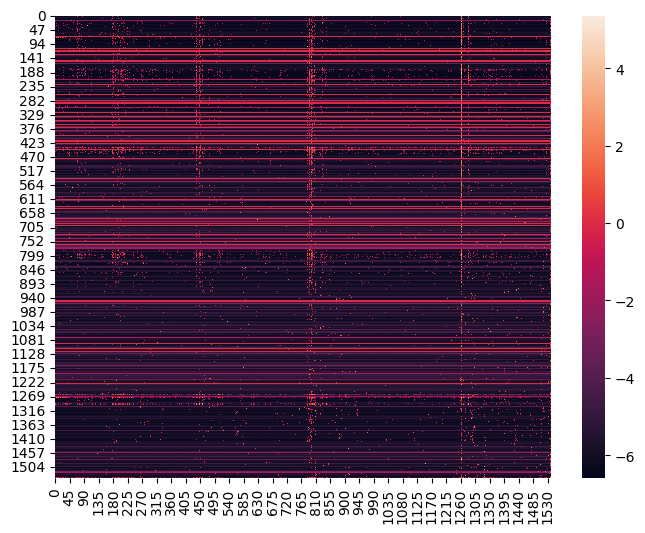

(tensor(4.1209, grad_fn=<DivBackward0>), np.float32(5.003311))

In [8]:
def eval_model( validation_steps = 100, pacience =  2, blocksize = 12, batchsize = 64):   
    # initalize and train the model
    m = BigramLanguageModel(len(vocab))
    training_steps = 1000000
    m.train(training_steps, validation_steps, pacience, blocksize, batchsize)
    trained_embedding = m.embedding_param.data
    loss = m.current_loss
    val_loss = m.validation_loss
    
    # plot a heatmap of the embedding for visalization purposes
    plt.figure(figsize=(8, 6))  
    sns.heatmap(trained_embedding) 
    plt.show()

    # save the embedding if less than k models have been saved or if the loss is better
    k = 5
    save_dir = 'n_grams'
    pattern = re.compile(r'trained_embedding_loss_([0-9.]+)\.npy')
    existing_files = [f for f in os.listdir(save_dir) if pattern.match(f)]

    # Extract losses from filenames
    losses = []
    for fname in existing_files:
        match = pattern.match(fname)
        if match:
            try:
                losses.append(float(match.group(1)))
            except ValueError:
                continue

    save_embedding = False
    if len(existing_files) < k: #less than k models saved
        save_embedding = True
    elif losses and loss < max(losses): # lower loss
        max_loss = max(losses)
        max_loss_file = [f for f in existing_files if f'trained_embedding_loss_{max_loss}' in f]
        for f in max_loss_file:
            os.remove(os.path.join(save_dir, f))
        save_embedding = True
    if save_embedding:
        np.save(os.path.join(save_dir, f'trained_embedding_loss_{loss}.npy'), trained_embedding)
    
    return loss, val_loss

eval_model()


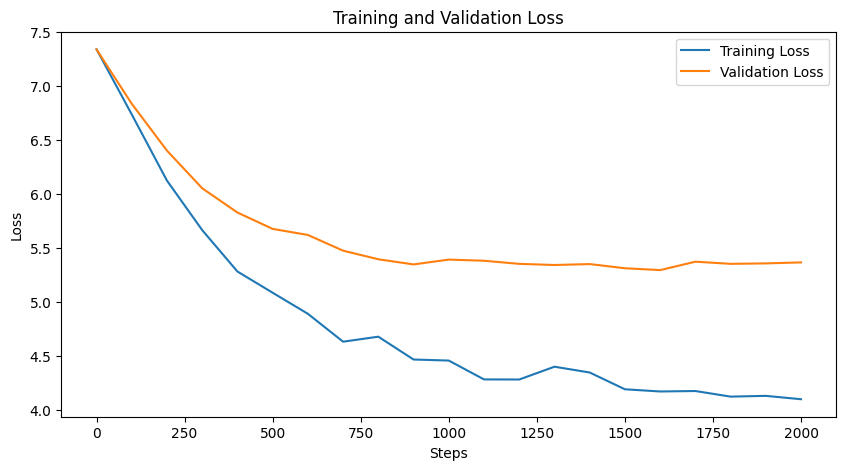

In [9]:
# plot the global validation loss and training loss 
plt.figure(figsize=(10, 5))
epochs = np.arange(len(global_loss)) * 100
val_epochs = np.arange(len(global_val_loss)) * 100
plt.plot(epochs, global_loss, label='Training Loss')
plt.plot(val_epochs, global_val_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [1]:
""" Very basic grid search to optimize the differnt hyperparameters """
default_validation_steps = 500
default_pacience =  5
default_blocksize = 8
default_seqsize = 64

validation_steps = [100, 250, 500]
patience =  [2,5]
blocksize = [ 32, 64, 8, 12]
seqsize = [256, 32,64,128]

In [ ]:
#Vary validation_steps
for v in validation_steps:
    loss, val = eval_model(validation_steps=v, pacience=default_pacience, blocksize=default_blocksize, batchsize=default_seqsize)
    print(f"validation_steps {v}, loss {loss}, val_loss {val}")

# Vary patience
for p in patience:
    loss, val = eval_model(validation_steps=default_validation_steps, pacience=p, blocksize=default_blocksize, batchsize=default_seqsize)
    print(f"patience {p}, loss {loss}, val_loss {val}")
    
# Vary seqsize
for bs in seqsize:
    loss, val = eval_model(validation_steps=default_validation_steps, pacience=default_pacience, blocksize=default_blocksize, batchsize=bs)
    print(f"seqsize {bs}, loss {loss}, val_loss {val}")

# Vary blocksize
for b in blocksize:
    loss, val = eval_model(validation_steps=default_validation_steps, pacience=default_pacience, blocksize=b, batchsize=default_seqsize)
    print(f"blocksize {b}, loss {loss}, val_loss {val}")

In [9]:
embedding = np.load(f"n_grams/trained_embedding_loss_4.120935440063477.npy")
m = BigramLanguageModel(len(vocab))
m.embedding_param.data = torch.from_numpy(embedding).float()

In [14]:
perplexity(val_data, embedding)

Perplexity: 151.90


151.89729942235704

In [14]:
# generate a sentence
starting_character = torch.zeros((1,1), dtype=torch.long)
starting_character[0] = 1284
generated_characters = m.generate(idx = starting_character, max_new_tokens=40)
generated_characters = generated_characters[0].tolist()
print(decode_characters(generated_characters))


i will strict in thy will some precement made one .' or ua friend . enter , to a more love me as doth in the nity of antony . o , bursed head 
